In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Fitpluse_Helath_Anomaly_Detection/Clean.csv')

In [ ]:
df

,Person ID,Gender,Age,Occupation,Job category,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Weight Category,Systolic Blood Pressure,Diastolic Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Timestamp
0,1,Male,27,Software Engineer,Science and Technology,6.1,6,42,6,Overweight,2,126,83,77,4200,NaN,2025-03-08 11:12:00
1,2,Male,28,Doctor,Healthcare,6.2,6,60,8,Normal,1,125,80,75,10000,NaN,2025-04-13 17:14:00
2,3,Male,28,Doctor,Healthcare,6.2,6,60,8,Normal,1,125,80,75,10000,NaN,2025-07-26 10:59:00
3,4,Male,28,Sales Representative,Business Management,5.9,4,30,8,Obese,3,140,90,85,3000,Sleep Apnea,2025-01-27 16:17:00
4,5,Male,28,Sales Representative,Business Management,5.9,4,30,8,Obese,3,140,90,85,3000,Sleep Apnea,2025-01-29 03:46:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,Healthcare,8.1,9,75,3,Overweight,2,140,95,68,7000,Sleep Apnea,2025-10-13 23:36:00
370,371,Female,59,Nurse,Healthcare,8.0,9,75,3,Overweight,2,140,95,68,7000,Sleep Apnea,2025-01-06 14:19:00
371,372,Female,59,Nurse,Healthcare,8.1,9,75,3,Overweight,2,140,95,68,7000,Sleep Apnea,2025-05-03 13:10:00
372,373,Female,59,Nurse,Healthcare,8.1,9,75,3,Overweight,2,140,95,68,7000,Sleep Apnea,2025-03-11 22:36:00


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='mixed')
df['id'] = df['Person ID'] # Use 'Person ID' as the unique identifier for time series
df = df.sort_values(['id', 'Timestamp'])

In [ ]:
from tsfresh import extract_features

# Define numerical columns for feature extraction
numerical_cols = [
    'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
    'Stress Level', 'Weight Category', 'Systolic Blood Pressure', 'Diastolic Blood Pressure',
    'Heart Rate', 'Daily Steps'
]

# Fill NaN values in all relevant numerical columns with 0
df[numerical_cols] = df[numerical_cols].fillna(0)
# Fill NaN values in 'Sleep Disorder' with a placeholder string (it won't be used for feature extraction)
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

# Create a subset DataFrame with only the relevant columns for tsfresh
df_for_tsfresh = df[['id', 'Timestamp'] + numerical_cols]

tsfresh_df = extract_features(
    df_for_tsfresh, # Use the subset DataFrame
    column_id='id', # Column that identifies the time series (now based on 'Person ID')
    column_sort='Timestamp', # Column that contains the time ordering of the observations
    column_kind=None, # Set to None, as the kind is implied by separate columns
    column_value=None, # Not specifying column_value, tsfresh will use all other columns
    default_fc_parameters=None # Use default feature calculators
)

Feature Extraction: 100%|██████████| 3740/3740 [05:00<00:00, 12.45it/s]


In [ ]:
tsfresh_df = tsfresh_df.fillna(0)

In [ ]:
from prophet import Prophet

def run_prophet(df, value_col):
    temp = df[['timestamp', value_col]].rename(
        columns={'timestamp': 'ds', value_col: 'y'}
    )

    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True
    )

    model.fit(temp)
    forecast = model.predict(temp)

    return forecast


In [ ]:
from sklearn.preprocessing import StandardScaler

X = tsfresh_df.values
X_scaled = StandardScaler().fit_transform(X)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
tsfresh_df['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=2.0, min_samples=10)
tsfresh_df['dbscan_cluster'] = db.fit_predict(X_scaled)


In [ ]:
from prophet import Prophet

def prophet_model(df, col):
    temp = df[['timestamp', col]].rename(
        columns={'timestamp': 'ds', col: 'y'}
    )

    model = Prophet(daily_seasonality=True)
    model.fit(temp)
    return model.predict(temp)


In [ ]:
user_id = 1
user_df = df[df['id'] == user_id].copy()
user_df = user_df.sort_values('Timestamp')

In [ ]:
from prophet import Prophet

def prophet_model(df, value_col):
    temp = df[['Timestamp', value_col]].rename(
        columns={'Timestamp': 'ds', value_col: 'y'}
    )

    # Check if there are enough data points for Prophet
    if len(temp) < 2:
        print(f"Skipping Prophet for '{value_col}' (ID: {df['id'].iloc[0]}) due to insufficient data (less than 2 rows).")
        # Return an empty DataFrame with the expected columns
        return pd.DataFrame(columns=['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat', 'y'])

    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
    )

    model.fit(temp)
    forecast = model.predict(temp)

    # Merge actual values back
    forecast = forecast.merge(
        temp[['ds', 'y']],
        on='ds',
        how='left'
    )

    return forecast

In [ ]:
# Check the number of entries for each 'Person ID'
df['id'].value_counts().head()

,count
id,
374,1
1,1
2,1
3,1
4,1


In [ ]:
from prophet import Prophet

def prophet_model(df, value_col):
    temp = df[['Timestamp', value_col]].rename(
        columns={'Timestamp': 'ds', value_col: 'y'}
    )

    # Check if there are enough data points for Prophet
    if len(temp) < 2:
        print(f"Skipping Prophet for '{value_col}' (ID: {df['id'].iloc[0]}) due to insufficient data (less than 2 rows).")
        # Return an empty DataFrame with the expected columns
        return pd.DataFrame(columns=['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat', 'y'])

    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
    )

    model.fit(temp)
    forecast = model.predict(temp)

    # Merge actual values back
    forecast = forecast.merge(
        temp[['ds', 'y']],
        on='ds',
        how='left'
    )

    return forecast

In [ ]:
from prophet import Prophet
import pandas as pd

# Rename columns using actual column names from df
df_prophet = df.rename(columns={
    "Timestamp": "ds",
    "Heart Rate": "y"
})

# Convert datetime
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"]).dt.tz_localize(None)

# Drop NaNs
df_prophet = df_prophet.dropna(subset=["y"])

# Train model
model = Prophet()
model.fit(df_prophet)

# Create future dataframe
future = model.make_future_dataframe(periods=10, freq="min")

# Predict
forecast = model.predict(future)

# Merge actual values back
forecast = forecast.merge(
    df_prophet[['ds', 'y']],
    on='ds',
    how='left'
)

forecast['residual'] = forecast['y'] - forecast['yhat']

print(forecast.columns)  # ds MUST be here

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'y', 'residual'],
      dtype='object')


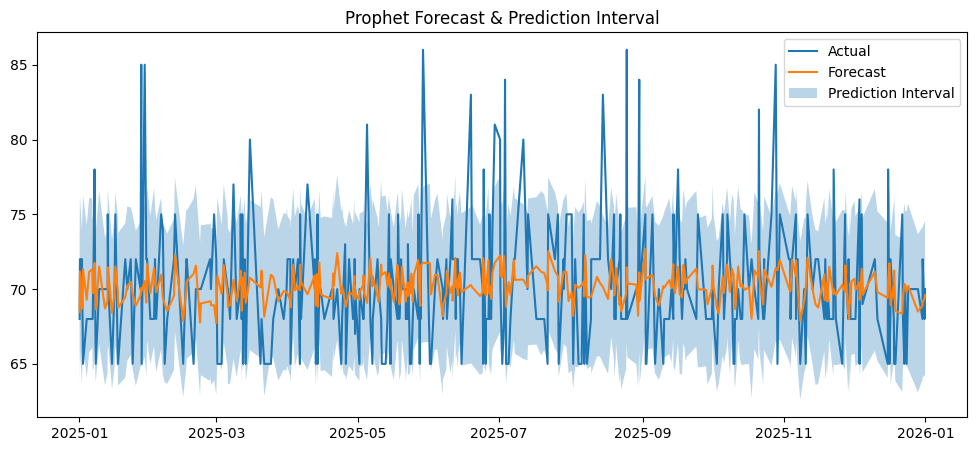

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(forecast['ds'], forecast['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    alpha=0.3,
    label='Prediction Interval'
)
plt.legend()
plt.title("Prophet Forecast & Prediction Interval")
plt.show()

In [ ]:
residual_std = forecast['residual'].std()

forecast['upper_threshold'] = forecast['yhat'] + 3 * residual_std
forecast['lower_threshold'] = forecast['yhat'] - 3 * residual_std


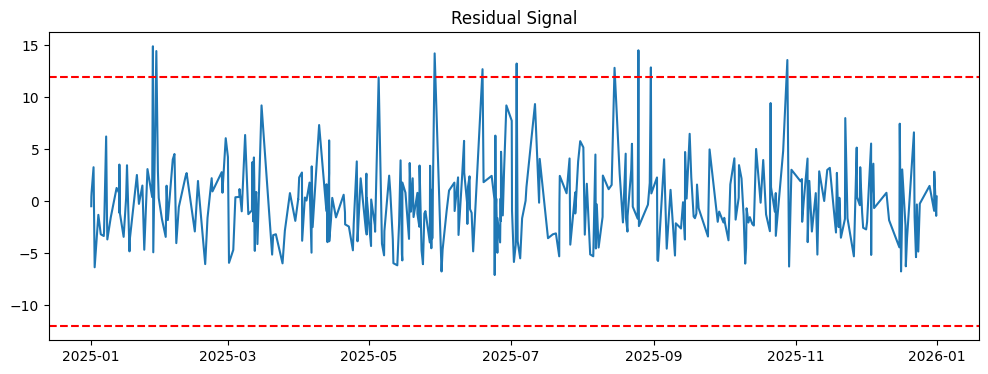

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(forecast['ds'], forecast['residual'])
plt.axhline(3*residual_std, color='red', linestyle='--')
plt.axhline(-3*residual_std, color='red', linestyle='--')
plt.title("Residual Signal")
plt.show()


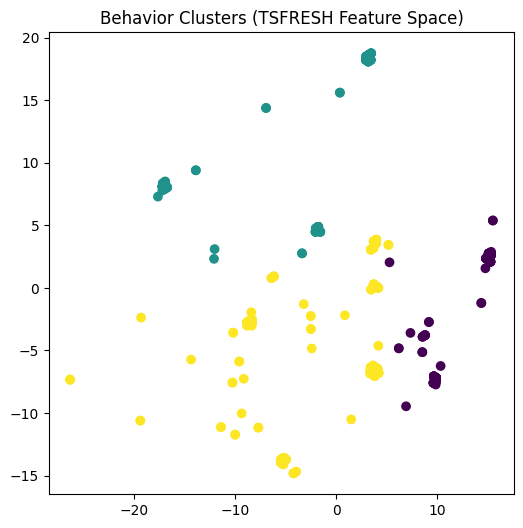

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=tsfresh_df['cluster'])
plt.title("Behavior Clusters (TSFRESH Feature Space)")
plt.show()
